# Transformations and coordinate systems

In this notebook, we will describe some usage principles for *transformations* and *coordinate systems* in {class}`spatialdata.SpatialData`.

In [1]:
import math

import matplotlib.pyplot as plt
import spatialdata as sd
import spatialdata_plot as sdp
from spatialdata.datasets import raccoon
from spatialdata.transformations import (
    Affine,
    Identity,
    MapAxis,
    Scale,
    Sequence,
    Translation,
    get_transformation,
    get_transformation_between_coordinate_systems,
    set_transformation,
)

for p in [sd, sdp]:
    print(f"{p.__name__}: {p.__version__}")

spatialdata: 0.2.3.dev2+ga2aab25
spatialdata_plot: 0.2.3.post1.dev68+gc8b0b34


We will use the {func}`spatialdata.datasets.raccoon` dummy dataset to showcase the usage of transformations and coordinate systems, that consits of:

- an image
- a segmentation mask
- few circles

Let's inspect the image's elements

## Image

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
SpatialData object
├── Images
│     └── 'raccoon': DataArray[cyx] (3, 768, 1024)
├── Labels
│     └── 'segmentation': DataArray[yx] (768, 1024)
└── Shapes
      └── 'circles': GeoDataFrame shape: (4, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        raccoon (Images), segmentation (Labels), circles (Shapes)


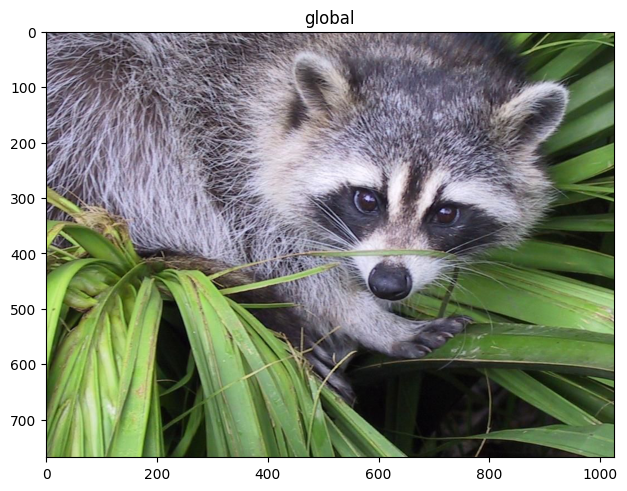

In [2]:
sdata = raccoon()

print(sdata)

sdata.pl.render_images().pl.show()

## Segmentation mask (as `labels`)

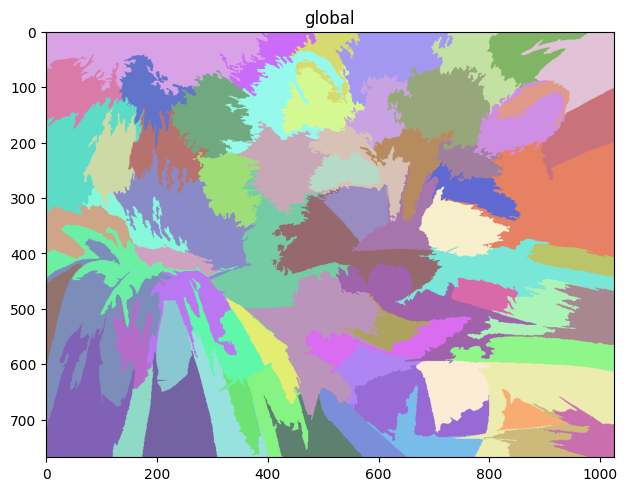

In [3]:
sdata.pl.render_labels().pl.show()

## Circles (as `shapes`)

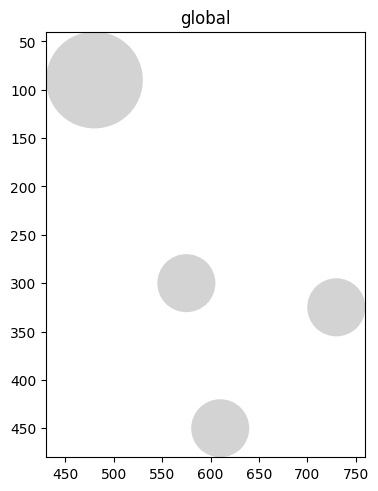

In [4]:
sdata.pl.render_shapes().pl.show()

We can either plot these separately or overlay them.

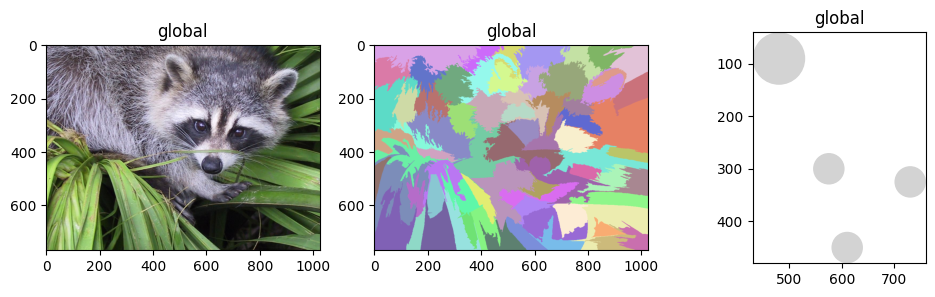

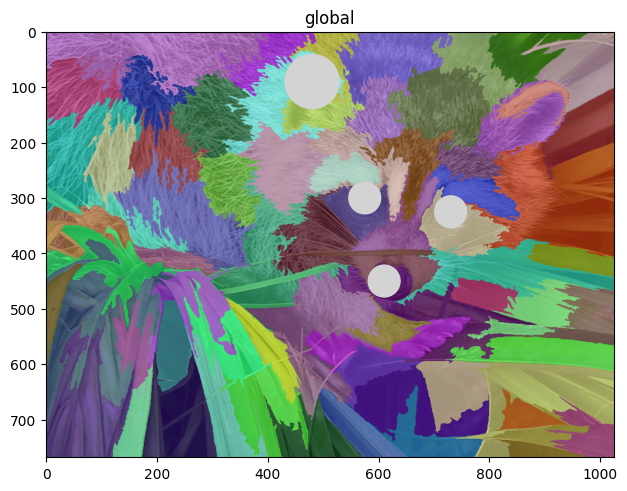

In [5]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

sdata.pl.render_images().pl.show(ax=axs[0])
sdata.pl.render_labels().pl.show(ax=axs[1])
sdata.pl.render_shapes().pl.show(ax=axs[2])

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

## Transformations and coordinate systems

In [6]:
sdata

SpatialData object
├── Images
│     └── 'raccoon': DataArray[cyx] (3, 768, 1024)
├── Labels
│     └── 'segmentation': DataArray[yx] (768, 1024)
└── Shapes
      └── 'circles': GeoDataFrame shape: (4, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        raccoon (Images), segmentation (Labels), circles (Shapes)

In the `repr` printed above, you can already see that the `SpatialData` object contains information on coordinate systems.

Specifically, each element can be aligned to one (or more) coordinate systems via a coordinate transformation (e.g. a translation or an affine transformation). See the figure.

<img src="attachments/coordinate_systems.png" alt="coordinate systems" style="max-width: 800px;">


Some details:
- with the current implementation coordinate transformations can only be specified between elements (left side of the figure) and coordinate systems (right side of the figure); they cannot be specified between elements, between coordinate systems, or between coordinate systems and elements.
- if the coordinates in the *intrinsic coordinate system of an element* (what is called "pixel" coordinate system above) are identical to the coordinates in the coordinate system the element is located, then the element will be mapped to that cooordinate system using an `Identity()` transformation.

Examples (shown in the figures below):
1. if you have one image and a set of points and the data is already aligned to each other (i.e. pixels and points coordinates corresponds without requiring transformations), then the configuration will be to have one coordinate system (the default name when it is not specified is called `global`, and two `Identity` transformations, each mapping one element to the common coordinate system.
2. if you have two sets of images and two sets of points, where the image 1 is alreaedy aligned to the points 1, and the image 2 is already aligned to the points 2, then a way to represent the data is to have two coordinate systems, for instance named `sample1` and `sample2`, and where all the 4 transformations are `Identity`.
3. finally suppose to have an image and points already aligned to the `sample1` coordinate system, as explained above, but now to have also a new image to align to sample 1 that is 2 times larger (in terms of pixels). We can align it using a `Scale` transformations.

Notes:
in the example aboves there were no rotations, nor translation (in particular the origin of all the images and points were identical); in the rest of the notebook we will examine more elaborate examples.

<img src="attachments/coordinate_transformations.png" alt="coordinate transformations" style="max-height: 800px;">

After this small theoretical introduction, let's go back to our code example. There are 3 elements aligned to the `global` coordinate system:

- `raccoon`: the raccoon image.
- `segmentation`: the segmentation mask.
- `circles`: the circles.

`global` is the default coordinate system that is added at the parsing stage, if no other transformation is specified. We can also expect that they are all {class}`spatialdata.transformations.Identity` transformations.
Let's print the availale coordinate systems in the SpatialData object and the transformations.

In [7]:
print(sdata.coordinate_systems)
print(
    get_transformation(sdata.images["raccoon"]),
    get_transformation(sdata.labels["segmentation"]),
    get_transformation(sdata.shapes["circles"]),
)

['global']
Identity  Identity  Identity 


In [8]:
# note: the results of these two functions are identical because global is the default argument for `to_coordinate_system`
get_transformation(sdata.images["raccoon"]) == get_transformation(
    sdata.images["raccoon"], to_coordinate_system="global"
)

True

Now that we understood what a transformation and a coordinate system are, let's see how we can use them.

Let's start by creating a new transformation, a simple {class}`spatialdata.transformations.Scale`. This transformation will scale the `"x"` axis by a factor of 2.

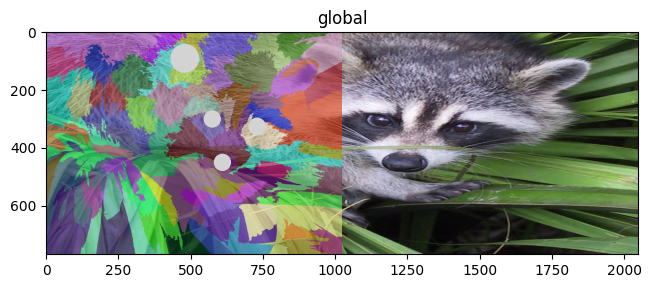

In [9]:
scale = Scale([2.0], axes=("x",))

set_transformation(sdata.images["raccoon"], scale, to_coordinate_system="global")

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

Note that our APIs allow us to apply and visualize transformations to raster and vector, with the same function call.

## Various transformations

Let's now explore various transformations available in `SpatialData`.

### MapAxis

The {class}`spatialdata.transformations.MapAxis` transformation can be used to permute the axis of the elements.

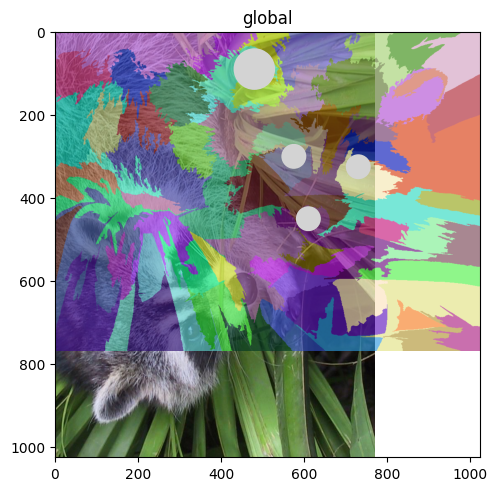

In [10]:
map_axis = MapAxis({"x": "y", "y": "x"})

set_transformation(sdata.images["raccoon"], map_axis, to_coordinate_system="global")

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

### Affine

The {class}`spatialdata.transformations.Affine` transformation can be used to apply an affine transformation to the elements. Let's start with a rotation.

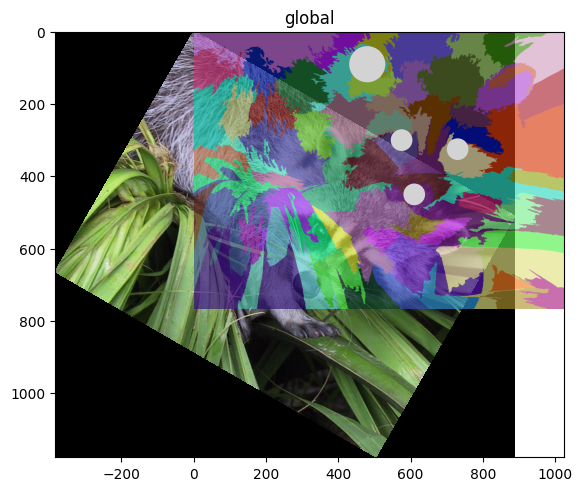

In [11]:
theta = math.pi / 6
rotation = Affine(
    [
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta), math.cos(theta), 0],
        [0, 0, 1],
    ],
    input_axes=("x", "y"),
    output_axes=("x", "y"),
)

set_transformation(sdata.images["raccoon"], rotation, to_coordinate_system="global")

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

### Translation

The {class}`spatialdata.transformations.Translation` transformation can be used to apply a translation to the element.

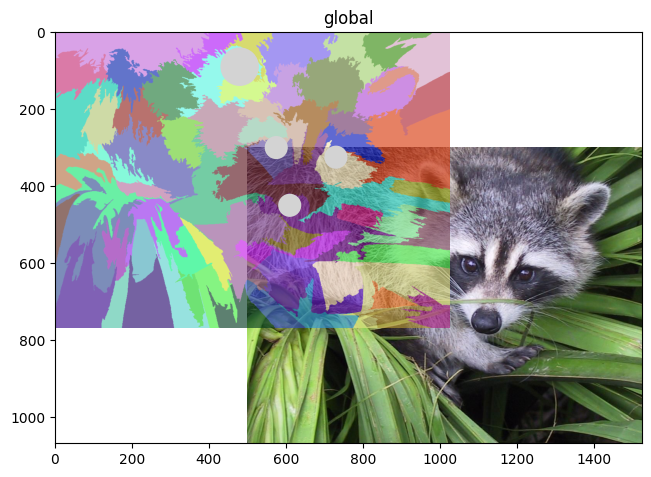

In [12]:
translation = Translation([500, 300], axes=("x", "y"))

set_transformation(sdata.images["raccoon"], translation, to_coordinate_system="global")

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

### Affine transformation and composition

The {class}`spatialdata.transformations.Sequence` transformation class can be used to compose transformations. This class allows to compose multiple transformations and it can be used even when the axes do not strictly match.

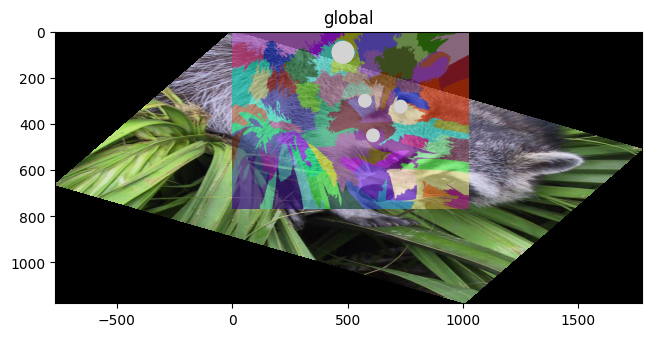

In [13]:
sequence = Sequence([rotation, scale])

set_transformation(sdata.images["raccoon"], sequence, to_coordinate_system="global")

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

We can also visualize the resulting affine matrix of the transformation.

In [14]:
print(sequence.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))

[[ 1.73205081 -1.          0.        ]
 [ 0.5         0.8660254   0.        ]
 [ 0.          0.          1.        ]]


As shown before, transformations can be applied to various elements without the constraint that the axes must match.
For example, a {class}`spatialdata.transformations.Scale` transformation over axis `"x"` can be applied both to circles and to images.

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[2. 0. 0.]                                                                                        
          [0. 1. 0.]                                                                                               
          [0. 0. 1.]]                                                                                              
         eigenvalues=[2. 1.]                                                                                       
         scale_factor=1.5                                                                                          


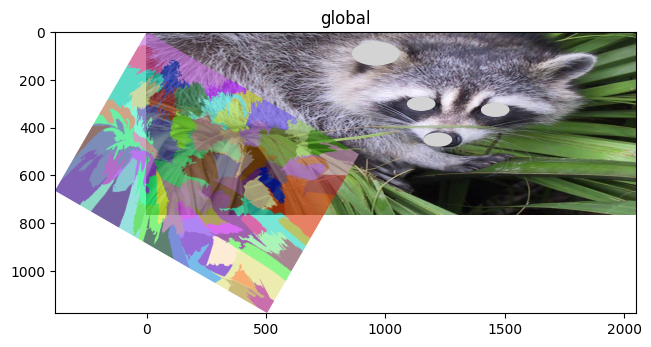

In [15]:
set_transformation(sdata.images["raccoon"], scale, to_coordinate_system="global")
set_transformation(sdata.shapes["circles"], scale, to_coordinate_system="global")
set_transformation(sdata.labels["segmentation"], rotation, to_coordinate_system="global")

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

### Inverse transformations

Most of the transformations also have an `inverse` method that returns the inverse transformation. If composed, they effectively cancel each other out.

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[2. 0. 0.]                                                                                        
          [0. 1. 0.]                                                                                               
          [0. 0. 1.]]                                                                                              
         eigenvalues=[2. 1.]                                                                                       
         scale_factor=1.5                                                                                          


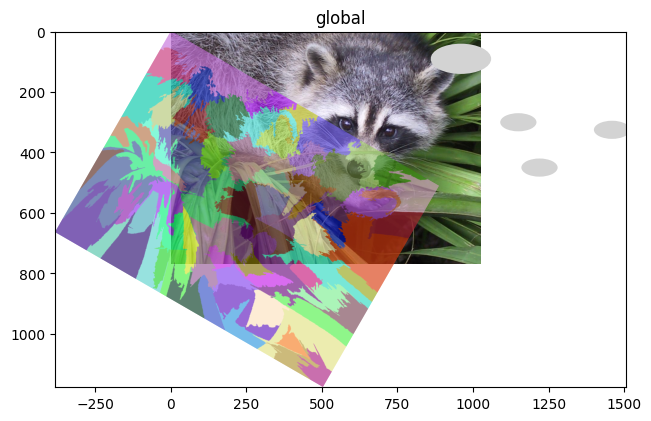

In [16]:
sequence = Sequence([rotation, rotation.inverse(), scale, scale.inverse()])

set_transformation(sdata.images["raccoon"], sequence, to_coordinate_system="global")

# the image will result untransformed because the inverse transformations cancel each others
sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

## Caveats!
There are three important clarifications to make to avoid sources of confusion. The first 2 are for all users, the 3rd is more technical and may be skipped.

### Known bug: pixel-perfectedness
When using APIs such as `transform()`, `rasterize()` and `transform_to_data_extent()` (all shown below), we may get a [misalignment of half-pixel magnitude](https://github.com/scverse/spatialdata/issues/165). We identified the root of the problem and we will make a fix in one of the next releases.

### Coordinate transformations vs `transform()`

When adding/remove coordinate transformations as we showed above, we are not modifying the actual data, but just some lightweight metadata. For instance, if you add a rotation transformation to an image, the image data will not get rotated. If you want, you can call the {func}`spatialdata.transform()` function to actually create a new image object with the rotated data.

Generally, applying a transformation to raster data is not recommended, and it is instead preferred to:
- leave the data as it is, and let downstream methods handle the transformation. An example of this is in `spatialdata-plot` and `napari-spatialdata`; in these libraries we never call `transform()` and rather delegate the task of transforming the data to `matplotlib` and `napari`, by passing to them the raw data and the transformation metadata.
- transform (or inverse-transform) the vector data: vector data is lighter than raster data, so transforming it is generally preferred. An example of this is in the query APIs of `spatialdata`, where we want to crop an image based on an input region from a different coordinate system. To do so we do not transform the images to the query coordinate system, but rather we inverse-transform the query region to the image ("pixel") space, and perform the query on the raw untransformed image.

<img src="attachments/spatialdata_registration.png" alt="coordinate transformations vs transform()" style="max-height: 800px;">

## Raster data and translations (technical topic)

The following is a technical topic, and may not be relevant for all users.

Due to some differences between the on-disk model (NGFF specification) and the in-memory model (Xarray), our current implementation is that if you call `transform()` on a raster object (image, labels), the translation part of the transformation will **not** be applied. Similarly, if you perform a query operation to the data, the returned raster data will contain a translation object to correct for the (0, 0) pixel.

This can create confusion because if you have an image and some points aligned to them, it may look like that after calling `transform()` the pixels of the image and the coordiantes of the points do not correspond anymore. But this is expected by design: the elements are not guaranteed to be aligned coordinate-wise, what is aligned is the data after applying a transformation to a common coordinate system, and since the image will still contain a translation, the alignment is preserved.

Let's discuss this via code in the examples below.

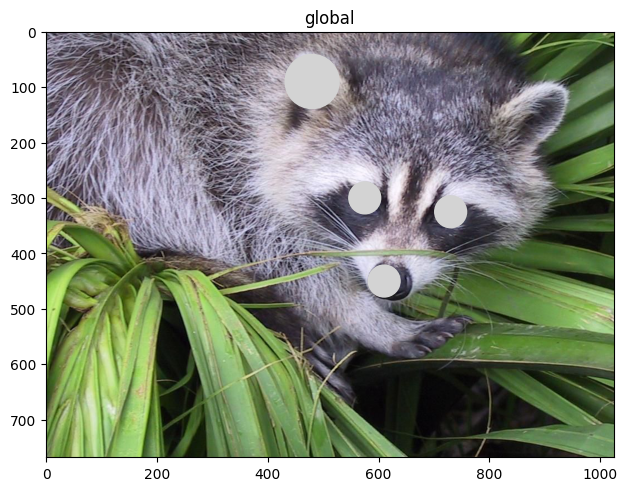

In [32]:
# let's restore the initial alignment between the raccoon image and circles

set_transformation(sdata["raccoon"], {"global": Identity()}, set_all=True)
set_transformation(sdata["circles"], {"global": Identity()}, set_all=True)

sdata.pl.render_images().pl.render_shapes().pl.show()

Let's translate the image and the circles. As you can see, `spatialdata-plot` shows the data correctly (notice how the x and y ranges change).

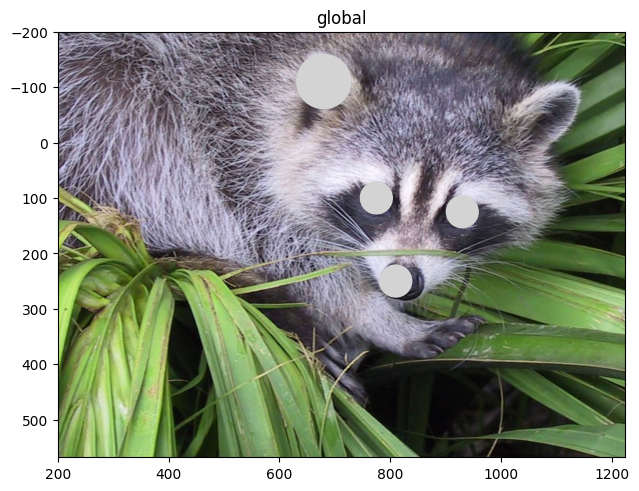

In [66]:
translation = Translation([200.0, -200], axes=("x", "y"))

set_transformation(sdata["raccoon"], translation)
set_transformation(sdata["circles"], translation)

sdata.pl.render_images().pl.render_shapes().pl.show()

Now let's transform the data, as you would expect, we obtain the same plot.

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `transformed_raccoon` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `transformed_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


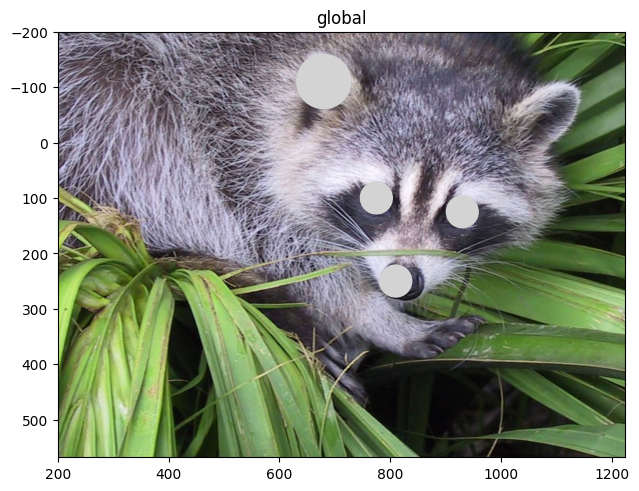

In [87]:
from spatialdata import transform

transformed_image = transform(sdata["raccoon"], to_coordinate_system="global")
transformed_circles = transform(sdata["circles"], to_coordinate_system="global")

sdata["transformed_raccoon"] = transformed_image
sdata["transformed_circles"] = transformed_circles

sdata.pl.render_images("transformed_raccoon").pl.render_shapes("transformed_circles").pl.show()

But notice how the image still contains a translation, while the circles now don't.

In [79]:
print(get_transformation(sdata["raccoon"]))
print(get_transformation(sdata["circles"]))
print(get_transformation(sdata["transformed_raccoon"]))
print(get_transformation(sdata["transformed_circles"]))

Translation (x, y)
    [ 200. -200.]
Translation (x, y)
    [ 200. -200.]
Translation (c, y, x)
    [   0. -200.  200.]
Identity 


This can create confusion. Let's manually plot the data to show the source of confusion.

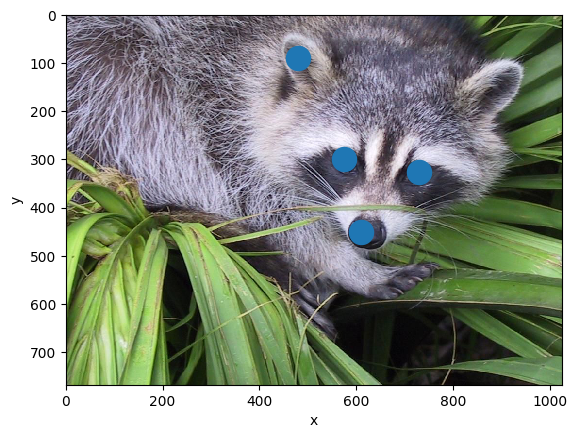

In [85]:
plt.figure()
ax = plt.gca()

sdata["raccoon"].plot.imshow(ax=ax, yincrease=False)
ax.scatter(sdata["circles"].geometry.centroid.x, sdata["circles"].geometry.centroid.y, s=300)

Below you will see that the data seems to be not aligned, but this is expected; as we saw above, when transformations are considered (e.g. when making the plot with `spatialdata-plot`) the data is correcly shown as aligned.

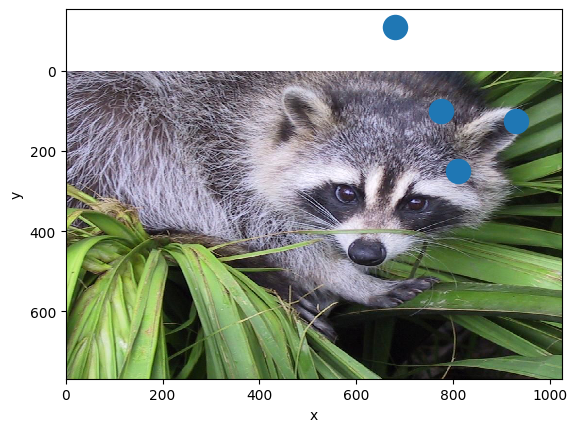

In [86]:
plt.figure()
ax = plt.gca()

sdata["transformed_raccoon"].plot.imshow(ax=ax, yincrease=False)
ax.scatter(sdata["transformed_circles"].geometry.centroid.x, sdata["transformed_circles"].geometry.centroid.y, s=300)

### Workarounds

Being aware of the implemented behavior is generally enough to avoid bugs like the one that appears in the plot above. 

Still, we have 2 functions that can be useful: the `rasterize()` function and then `transform_to_data_extent()`.

The first function, `rasterize()`, lets you rasterize the data into a target bounding box specified in a desired coordinate system. Translation/rotations/etc will be applied and 0 (black) will be used to pad all the portions of the image outside its extent. This function can be helpful because it "pads" the translation part with 0.

In [88]:
from spatialdata import rasterize

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `rasterized_raccoon` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


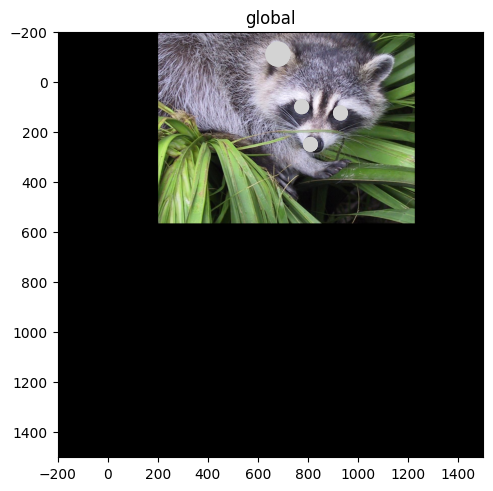

In [98]:
rasterized_raccoon = rasterize(
    sdata["raccoon"],
    min_coordinate=[-200, -200],
    max_coordinate=[1500, 1500],
    axes=("x", "y"),
    target_coordinate_system="global",
    target_unit_to_pixels=1,
)
sdata["rasterized_raccoon"] = raccoon_rasterized

sdata.pl.render_images("rasterized_raccoon").pl.render_shapes().pl.show()

The second function, `transform_to_data_extent()`, first computes the extent of the data using `spatialdata.get_extent()` and then transforms all the elements (images, shapes, etc) to the data extent such that all the elemnts will have the same transformation. In this way the correspondance between pixels and coordinates is guaranteed.

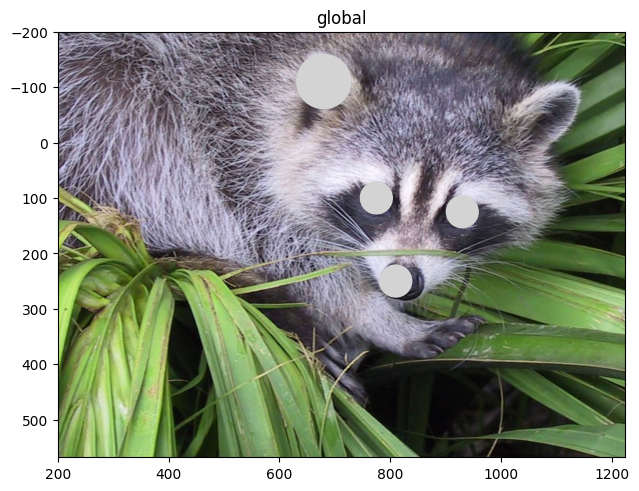

In [107]:
from spatialdata._core.operations._utils import transform_to_data_extent

sdata2 = transform_to_data_extent(
    sdata.subset(["raccoon", "circles"]), coordinate_system="global", target_unit_to_pixels=1
)
sdata2.pl.render_images().pl.render_shapes().pl.show()

Crucially, now all the elements have the same transformation (up to half pixel difference, due to the bug referenced above)!

In [122]:
print("before:")
# before (raster data still has the translation but not the vector data)
print(get_transformation(sdata["transformed_raccoon"]))
print(get_transformation(sdata["transformed_circles"]))

print("\nafter:")
# all the data has the same transformation
print(get_transformation(sdata2["raccoon"]))
print(get_transformation(sdata2["circles"]))

before:
Translation (c, y, x)
    [   0. -200.  200.]
Identity 

after:
Sequence 
    Translation (z, y, x)
        [-0.5 -0.5 -0.5]
    Scale (y, x)
        [1. 1.]
    Translation (y, x)
        [-200.  200.]
    Translation (z, y, x)
        [0.5 0.5 0.5]
Sequence 
    Sequence 
        Scale (y, x)
            [1. 1.]
        Translation (y, x)
            [-200.  200.]
        Identity 


This means that now we can manually slice both the raster and vector data, since they are aligned together also in the intrinsic ("pixel") coordinate system. 

Text(0.5, 1.0, 'after')

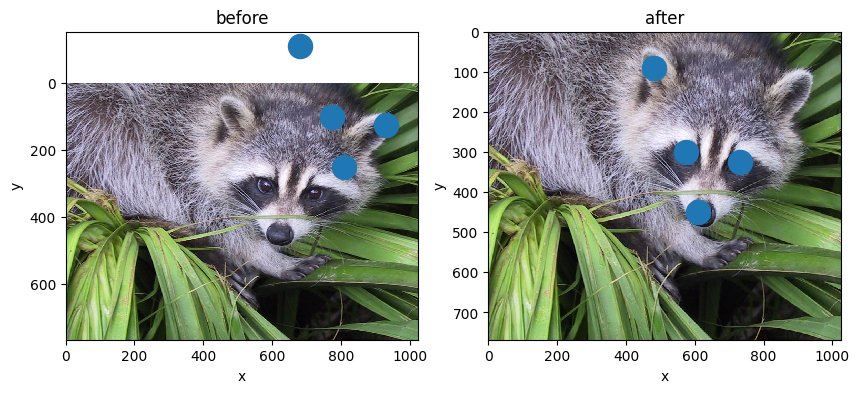

In [119]:
axes = plt.subplots(1, 2, figsize=(10, 4))[1]

sdata["transformed_raccoon"].plot.imshow(ax=axes[0], yincrease=False)
axes[0].scatter(
    sdata["transformed_circles"].geometry.centroid.x, sdata["transformed_circles"].geometry.centroid.y, s=300
)
axes[0].set_title("before")

sdata2["raccoon"].plot.imshow(ax=axes[1], yincrease=False)
axes[1].scatter(sdata2["circles"].geometry.centroid.x, sdata2["circles"].geometry.centroid.y, s=300)
axes[1].set_title("after")

### A simpler approach that we will implement

Let's show a preview of what we are implementing next. Here we are slicing the vector and raster data using the `xarray` and `geopandas` APIs (no coordinate systems are used, we operate on the coordinates).

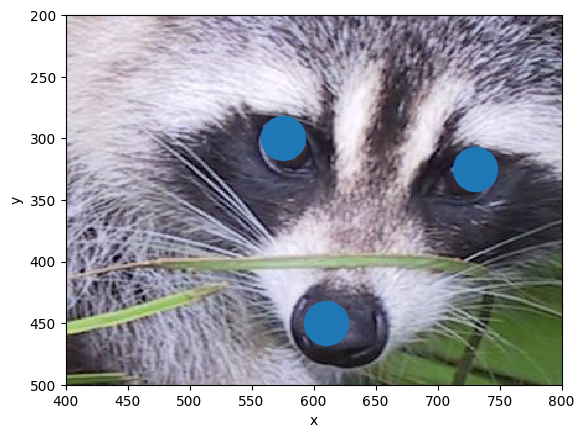

In [120]:
# let's manually slice the data
x_slice = slice(400, 800)
y_slice = slice(200, 500)

# .sel is the coordinate based indexed available via geopandas APIs
image_slice = sdata["raccoon"].sel(x=x_slice, y=y_slice)
# .cx is the coordinate based indexed available via geopandas APIs
circles_slice = sdata["circles"].cx[x_slice, y_slice]

plt.figure()
ax = plt.gca()

image_slice.plot.imshow(ax=ax, yincrease=False)
ax.scatter(circles_slice.geometry.centroid.x, circles_slice.geometry.centroid.y, s=1000)

The simplicity of the operation above comes with several limitations, in particular:
- no affine transformations are supported
- no support for multiple coordinate systems
- the transformations are not serialized in a interoperable format like NGFF.

We designed and are gradually implementing a new system that will bridge the NGFF transformations and the coordinate-based xarray approach to transformations. This will enable to interchengeably write code that operates on the NGFF transformations and on the xarray coordiantes (as shown in the code snipepd above). This will greatly simplify the challenges discussed previously, without sacrificing the power of NGFF transformations. See the status of our implementation here: https://github.com/scverse/spatialdata/issues/308.

## Technical topics

Let's conclude the tutorial with some important, but more technical, topics.

### Transformations and Axes

As quickly shown above, given a transformation object, we can compute an affine matrix from it with the {meth}`spatialdata.transformations.Transformation.to_affine_matrix` method.
This method takes as input the axes of the input element and the axes of the output element. The affine matrix is built consistently according to the input and output axes.

Let's see an example.

In [17]:
print(translation.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))
print(translation.to_affine_matrix(input_axes=("x", "y", "z"), output_axes=("x", "y", "z")))

[[  1.   0. 500.]
 [  0.   1. 300.]
 [  0.   0.   1.]]
[[  1.   0.   0. 500.]
 [  0.   1.   0. 300.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


The affine matrix is built consistently according to the input and output axes; the axes at input and output can also have mismatch and the affine matrix will be built accordingly.

This is what interally allows to specify the same transformations to different types of elements (for instance xyz points and cyx images) and still get consistent results.

In [18]:
print(translation.to_affine_matrix(input_axes=("x", "y", "c"), output_axes=("c", "z", "y", "x")))

[[  0.   0.   1.   0.]
 [  0.   0.   0.   0.]
 [  0.   1.   0. 300.]
 [  1.   0.   0. 500.]
 [  0.   0.   0.   1.]]


notice that z doesn't appear in the output axes since it was not in the input axes, but c is passed through since it was in the input axes
This is the same matrix that gets printed as output above.

|   | x | y | c |   |
|----|---|---|---|---|
| c | 0 | 0 | 1 | 0 |
| z | 0 | 0 | 0 | 0 | |
| y | 0 | 1 | 0 | 300 |
| x | 1 | 0 | 0 | 500 |
|   | 0 | 0 | 0 | 1 |

### Transformations between coordinate systems

As we mentioned before, `SpatialData` doesn't allow to store transformations between coordinate systems, or between elements, only between elements and coordinate systems. Still, `SpatialData` also allows to compute the transformation between any pair of {element, coordinate system). This is possible with using the {func}`spatialdata.ops.get_transformation_between_coordinate_systems` function, which internally computes the graph of transformations and finds a path among transformations and their inverses (when they exist).

The function takes as argument the `SpatialData` object and the names of the coordinate systems.
It returns the transformation that needs to be applied to the elements in the first coordinate system to be converted to the second coordinate system.

Let's see an example.


In [19]:
set_transformation(sdata.images["raccoon"], rotation)
print(get_transformation_between_coordinate_systems(sdata, sdata.images["raccoon"], "global"))
print(get_transformation_between_coordinate_systems(sdata, "global", sdata.images["raccoon"]))

Sequence 
    Affine (x, y -> x, y)
        [ 0.8660254 -0.5        0.       ]
        [0.5       0.8660254 0.       ]
        [0. 0. 1.]
Sequence 
    Affine (x, y -> x, y)
        [0.8660254 0.5       0.       ]
        [-0.5        0.8660254  0.       ]
        [0. 0. 1.]


In the example above, we are effectively only returning the transformation that is needed to map the elements to the `global` coordinate system.
Notice how one transformation is the inverse of the other.

To complete the example, let's use the function to derive a transformation between different coordinate systems (above we used it to derive the transformation between a coordinate system and an element).
We first need to create a new coordinate system for some of the elements. We will just assign an {class}`spatialdata.transformations.Identity` transfomation.

In [20]:
set_transformation(sdata.images["raccoon"], Identity(), "my_other_space0")
print(get_transformation(sdata.images["raccoon"], get_all=True))
print(sdata.coordinate_systems)

{'global': Affine (x, y -> x, y)
    [ 0.8660254 -0.5        0.       ]
    [0.5       0.8660254 0.       ]
    [0. 0. 1.], 'my_other_space0': Identity }
['my_other_space0', 'global']


We then get the transformation between the `"global"` coordinate system and the `"my_other_space0"` coordinate system.

As expected, it is a {class}`spatialdata.transformations.Sequence` transformation with an {class}`spatialdata.transformations.Affine` and an {class}`spatialdata.transformations.Identity` composed.

In [21]:
get_transformation_between_coordinate_systems(sdata, "global", "my_other_space0")

Sequence 
    Affine (x, y -> x, y)
        [0.8660254 0.5       0.       ]
        [-0.5        0.8660254  0.       ]
        [0. 0. 1.]
    Identity 